In [63]:
# import libs

from ortools.linear_solver import pywraplp
from ortools.init import pywrapinit
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

from scipy.spatial import distance_matrix

import numpy as np
import numpy.random as nr
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd

import random
import copy
import time
import itertools


In [353]:
# init parameters

NO_TOWNS = 100 # number of towns (town numbering is from [0, NO_TOWNS-1])
NO_AGENTS = 1
STARTING_TOWN = 0 # set starting town
nr.seed(69) # set fixed seed for rng



In [354]:
# function for creating town coordinates
def create_towns(NO_TOWNS):
    """generate random x and y coordinates for each town"""

    towns_x = nr.randint(0, 100, NO_TOWNS) # x coordinates for NO_TOWNS number of towns
    towns_y = nr.randint(0, 100, NO_TOWNS) # y coordinates for NO_TOWNS number of towns
    
    return towns_x, towns_y


towns_x, towns_y = create_towns(NO_TOWNS) # generate coordinates for each town

start_town_x = towns_x[STARTING_TOWN]
start_town_y = towns_y[STARTING_TOWN]

In [355]:
def create_distance_matrix(towns_x, towns_y):
    """create a matrix of pairwise distances between all towns"""
    towns = list(range(NO_TOWNS))
    df = pd.DataFrame(np.array([towns_x, towns_y]).transpose(), columns=['x', 'y'], index=towns)
    distance_df = pd.DataFrame(distance_matrix(df.values, df.values), index=df.index, columns=df.index)
    return np.round_(distance_df).astype(int)

def create_waiting_time_matrix():
    """create a matrix of waiting times at each town"""
    
    matrix = nr.randint(0, 30, NO_TOWNS)
    matrix[0] = 0
    
    return matrix


dist_matrix = create_distance_matrix(towns_x, towns_y)
waiting_time_matrix = create_waiting_time_matrix()


In [356]:
waiting_time_matrix

array([ 0, 26,  3, 21, 20,  1, 25,  3, 15, 19, 28, 13,  8, 16, 23, 19,  0,
       22,  4,  9, 25,  6, 15, 21, 27, 17, 21, 18, 20, 12, 16, 11, 25, 24,
       22,  0, 11, 17, 21, 24,  9,  9, 20, 11, 23, 26,  8, 15, 13, 23,  9,
       24, 10, 25,  4, 19, 23,  2,  2, 21, 25, 13, 16, 10, 14,  2, 22, 27,
       19, 18, 14,  8, 10, 18, 27, 12, 18, 27,  9, 16,  4, 26, 14, 19, 20,
        1, 10, 24,  3, 19, 17,  1, 13, 24, 21,  9, 16, 21,  1,  2])

In [357]:
def create_data_model():
    """Stores the data for the problem."""
    data = {}
    data['dist_matrix'] = dist_matrix
    data['waiting_time_matrix'] = waiting_time_matrix
    data['num_vehicles'] = NO_AGENTS
    data['depot'] = STARTING_TOWN
    
    return data


def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    print(f'Objective: {solution.ObjectiveValue()}\n')
    
    max_route_distance = 0
    max_waiting_time = 0
    routes = []
    route_distances = []
    route_waiting_times = []
    
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        
        route = []
        route_distance = 0
        route_waiting_time = 0
        
        while not routing.IsEnd(index):
            plan_output += ' {} -> '.format(manager.IndexToNode(index))
            route.append(manager.IndexToNode(index))
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
            route_waiting_time += data['waiting_time_matrix'][manager.IndexToNode(index)]
        
        routes.append(route)
        route_distances.append(route_distance)
        route_waiting_times.append(route_waiting_time)
        
        plan_output += '{}\n'.format(manager.IndexToNode(index))
        plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        plan_output += 'Total Waiting Time along route: {} minutes\n'.format(route_waiting_time)
        print(plan_output)
        max_route_distance = max(route_distance, max_route_distance)
        max_waiting_time = max(route_waiting_time, max_waiting_time)
        
    print('Maximum of the route distances: {}m'.format(max_route_distance))
    print('Maximum of the waiting times: {} minutes'.format(max_waiting_time))
    
    return routes, route_distances, route_waiting_times


In [358]:
# Creating callback function for travelling distance cost

def distance_callback(from_index, to_index):
    """Returns the distance between the two nodes."""
    # Convert from routing variable Index to distance matrix NodeIndex.
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    
    return data['dist_matrix'][from_node][to_node]

# Creating callback function for waiting time cost
def waiting_time_callback(to_index):
    """Returns the waiting time at a node"""
    # Convert from routing variable index to time matrix NodeIndex
    to_node = manager.IndexToNode(to_index)
    
    return data['waiting_time_matrix'][to_node]

def cost_callback(from_index, to_index):
    """Returns the total cost"""
    return distance_callback(from_index, to_index) + 4*waiting_time_callback(to_index)

In [359]:
"""Entry point of the program."""

walltime = time.time()
cputime = time.process_time()

# Instantiate the data problem.
data = create_data_model()

# Create the routing index manager.
manager = pywrapcp.RoutingIndexManager(len(data['dist_matrix']),
                                       data['num_vehicles'], data['depot'])

# Create Routing Model.
routing = pywrapcp.RoutingModel(manager)


# Create and register a transit callback.
transit_callback_index = routing.RegisterTransitCallback(distance_callback)

# Define cost of each arc.
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)


# Add Distance constraint.
routing.AddDimension(
    transit_callback_index,
    0,  # no slack
    5000,  # vehicle maximum travel distance
    True,  # start cumul to zero
    'Distance')


distance_dimension = routing.GetDimensionOrDie('Distance')
distance_dimension.SetGlobalSpanCostCoefficient(100)


# Setting first solution heuristic.
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = (
    routing_enums_pb2.FirstSolutionStrategy.AUTOMATIC)

# Setting time limit on solver
search_parameters.time_limit.seconds = 60

# Solve the problem.
solution = routing.SolveWithParameters(search_parameters)

self_walltime = time.time()-walltime
self_cputime = time.process_time()-cputime

print('Wall time', self_walltime)
print('CPU time', self_cputime)

# Print solution on console.
if solution:
    routes, route_distances, route_waiting_times = print_solution(data, manager, routing, solution)
else:
    print('No solution found !')


Wall time 60.04785370826721
CPU time 58.71875
Objective: 84941

Route for vehicle 0:
 0 ->  26 ->  29 ->  61 ->  72 ->  38 ->  68 ->  12 ->  51 ->  19 ->  55 ->  33 ->  10 ->  80 ->  42 ->  27 ->  47 ->  23 ->  3 ->  62 ->  16 ->  2 ->  37 ->  79 ->  32 ->  75 ->  60 ->  69 ->  11 ->  94 ->  30 ->  34 ->  57 ->  84 ->  86 ->  71 ->  18 ->  74 ->  8 ->  76 ->  46 ->  35 ->  21 ->  99 ->  91 ->  7 ->  81 ->  5 ->  14 ->  52 ->  54 ->  96 ->  85 ->  25 ->  41 ->  50 ->  40 ->  90 ->  22 ->  87 ->  92 ->  56 ->  63 ->  20 ->  53 ->  45 ->  44 ->  65 ->  98 ->  59 ->  43 ->  73 ->  89 ->  78 ->  17 ->  6 ->  67 ->  83 ->  58 ->  82 ->  36 ->  70 ->  15 ->  31 ->  24 ->  64 ->  95 ->  66 ->  1 ->  97 ->  13 ->  77 ->  48 ->  28 ->  39 ->  88 ->  93 ->  49 ->  9 ->  4 -> 0
Distance of the route: 841m
Total Waiting Time along route: 1514 minutes

Maximum of the route distances: 841m
Maximum of the waiting times: 1514 minutes


In [360]:
def plot_routes(routes):
    """plot the routes for each vehicle"""
    
    plt.figure(figsize=(6, 6))
    
    # loop through vehicles
    
    for route in routes:
        closed_route = route.append(STARTING_TOWN)
        plt.plot(towns_x[route], towns_y[route], 'o-')
        plt.plot(towns_x[STARTING_TOWN], towns_y[STARTING_TOWN], 'or', markerfacecolor='w') #indicate start position with X
        plt.title(f'OR-Tools VRP Solver\n{NO_TOWNS} Waypoints, {NO_AGENTS} Robots\nTime taken: {self_walltime:.3}s')
        
#     for town in range(NO_TOWNS):
#         plt.text(towns_x[town]+1, towns_y[town]+1, s=waiting_time_matrix[town])

#     for town in range(NO_TOWNS):        
#         plt.text(towns_x[town]-1, towns_y[town]-3, s=town, c='red')

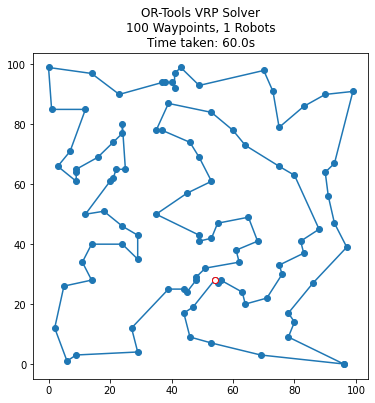

In [361]:
plot_routes(routes)

# With 'Waiting Time' cost

In [332]:
"""Entry point of the program."""

walltime = time.time()
cputime = time.process_time()

# Instantiate the data problem.
data = create_data_model()

# Create the routing index manager.
manager = pywrapcp.RoutingIndexManager(len(data['dist_matrix']),
                                       data['num_vehicles'], data['depot'])

# Create Routing Model.
routing = pywrapcp.RoutingModel(manager)


# Create and register a transit callback.
transit_callback_index = routing.RegisterTransitCallback(distance_callback)

# Define cost of each arc.
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

# Create and register a waiting time callback.
wait_callback_index = routing.RegisterUnaryTransitCallback(waiting_time_callback)

# Add Distance constraint.
routing.AddDimension(
    transit_callback_index,
    0,  # no slack
    1000,  # vehicle maximum travel distance
    True,  # start cumul to zero
    'Distance')

# Add Waiting Time constraint
routing.AddDimension(
    wait_callback_index,
    0,
    200,
    True,
    'Waiting Time')

distance_dimension = routing.GetDimensionOrDie('Distance')
distance_dimension.SetGlobalSpanCostCoefficient(100)

time_dimension = routing.GetDimensionOrDie('Waiting Time')
time_dimension.SetGlobalSpanCostCoefficient(100)

# Setting first solution heuristic.
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = (
    routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

# Setting time limit on solver
search_parameters.time_limit.seconds = 30

# Solve the problem.
solution = routing.SolveWithParameters(search_parameters)

self_walltime = time.time()-walltime
self_cputime = time.process_time()-cputime

print('Wall time', self_walltime)
print('CPU time', self_cputime)

# Print solution on console.
if solution:
    routes, route_distances, route_waiting_times = print_solution(data, manager, routing, solution)
else:
    print('No solution found !')


Wall time 30.018399477005005
CPU time 29.3125
Objective: 38606

Route for vehicle 0:
 0 ->  9 ->  39 ->  3 ->  23 ->  10 ->  12 ->  42 ->  51 ->  55 ->  28 ->  19 ->  1 -> 0
Distance of the route: 198m
Total Waiting Time along route: 176 minutes

Route for vehicle 1:
 0 ->  49 ->  27 ->  16 ->  59 ->  36 ->  15 ->  6 ->  58 ->  29 ->  45 ->  4 -> 0
Distance of the route: 177m
Total Waiting Time along route: 177 minutes

Route for vehicle 2:
 0 ->  31 ->  21 ->  25 ->  40 ->  14 ->  52 ->  30 ->  24 ->  11 ->  32 ->  26 ->  44 -> 0
Distance of the route: 154m
Total Waiting Time along route: 162 minutes

Route for vehicle 3:
 0 ->  56 ->  20 ->  17 ->  43 ->  2 ->  37 ->  13 ->  47 ->  33 ->  48 ->  38 -> 0
Distance of the route: 184m
Total Waiting Time along route: 145 minutes

Route for vehicle 4:
 0 ->  54 ->  7 ->  5 ->  46 ->  34 ->  50 ->  57 ->  22 ->  18 ->  8 ->  41 ->  35 ->  53 -> 0
Distance of the route: 193m
Total Waiting Time along route: 179 minutes

Maximum of the route d

In [333]:
def plot_routes(routes):
    """plot the routes for each vehicle"""
    
    plt.figure(figsize=(6, 6))
    
    # loop through vehicles
    
    for route in routes:
        closed_route = route.append(STARTING_TOWN)
        plt.plot(towns_x[route], towns_y[route], 'o-')
        plt.plot(towns_x[STARTING_TOWN], towns_y[STARTING_TOWN], 'or', markerfacecolor='w') #indicate start position with X
        plt.title(f'OR-Tools VRP Solver\n{NO_TOWNS} Waypoints, {NO_AGENTS} Robots\nTime taken: {self_walltime:.3}s')
        
    for town in range(NO_TOWNS):
        
#         plt.text(towns_x[town]-1, towns_y[town]-3, s=town, c='red')
        plt.text(towns_x[town]+2, towns_y[town]+2, s=waiting_time_matrix[town])
        

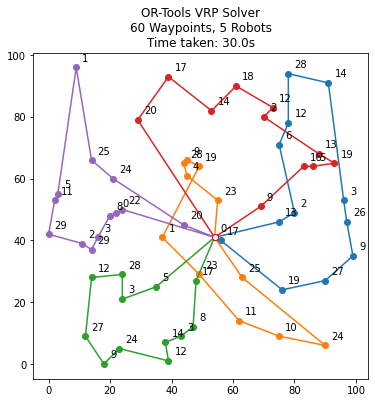

In [334]:
plot_routes(routes)